In [1]:
import os
import math
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from torchsummary import summary
from torchtext.datasets import IWSLT2017
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset, load_metric
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchtext.vocab import build_vocab_from_iterator
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, T5ForConditionalGeneration, AdamW, get_scheduler

/home/benny/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/benny/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/benny/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchtext/vocab/__init__.py:4: UserWa

In [2]:
torch.cuda.is_available()

True

# 一. Scaled Dot-Product Attention機制

![jupyter](./scaled_dot_product_attention.png)

假設我們以$d$維的tensor來表示圖片。現有一張圖片$\mathbf{Q}$ (query)這張圖片中某一個部分為$\mathbf{K}$ (key)，例如一個瓶子或一張桌子。我們問：另一張以$d$維的tensor來表示的圖片$\mathbf{V}$ (value)之中，在與$\mathbf{Q}$相同的位置上有沒有$\mathbf{K}$的存在呢？

可以將將$\mathbf{Q}$和$\mathbf{K}$相乘後，$\mathbf{Q}$與$\mathbf{K}$相近的部分將會擁有比較大的值。新得出的tensor稱為attention map。此attention map再經過一個scale(以及一個mask會把某些部分的值換成一個很接近0的數字，如果有必要的話)，避免它的值爆掉。接著按照機器學習的老招數經過SoftMax值，我們就得到了一個直觀上功能類似filter的tensor，稱為attention weight。將此attention weight跟$\mathbf{V}$相乘，就可以找出$\mathbf{V}$在相同位置上是否有類似$\mathbf{K}$的存在。

attention weight可以通過一個dropout層避免overfitting。

注意：Scaling的時候並沒有規定一定要除以(或乘以)多少。它的目的只是避免值爆掉導致梯度算不出來。注意$\mathbf{K}$未必是$d$維的tensor，但我們可以透過replication和padding或其他方式讓它變成$d$維。

依上圖可以將此結構寫出來。注意到在這個函式中沒有任何參數需要訓練。

In [3]:
def scaled_dot_product_attention(query, key, value, dropout_p=0.0, mask=None, scale=None) -> torch.Tensor:
    
    # 1. 計算attention map
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale # Scaling by sqrt of key dimension
    attn_weight = torch.matmul(query, key.transpose(-2, -1)) * scale_factor # Matrix multiplication
    
    # 2. 有些計算attention weight的過程會要加上某些bias，但這裡省略掉
#     L, S = query.size(-2), key.size(-2)
#     attn_bias = torch.zeros(L, S, dtype=query.dtype)
#     attn_weight += attn_bias
    
    # 3. 通過softmax層
    attn_weight = torch.softmax(attn_weight, dim=-1)
    
    if mask is not None:
        attn_weight = attn_weight.masked_fill(mask == 0, -1e9)
    
    # 4. 通過dropout層:避免over fitting
    attn_weight = nn.functional.dropout(attn_weight, p=dropout_p, training=True)
    
    # 5. 計算attention weight與value相乘並回傳
    return torch.matmul(attn_weight, value), attn_weight

## 1. 以實際的圖片為例，可視化Scaled Dot-Product Attentionk的物理意義

首先我們以一個三維的張量來表示一張圖片的RGB三個顏色。需要一個能夠顯示以pytorch的張量來顯示圖片的函式。

In [4]:
def show_image(image_tensor):
    # Convert the tensor to a numpy array and transpose it to [H, W, C]
    image_np = image_tensor.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis
    plt.show()

### (1) 產生query
打開圖片，這張圖片就會是我們的query $\mathbf{Q}$。

In [5]:
image_path = 'IMG_7241.JPG'
image = Image.open(image_path)
transform = transforms.ToTensor()
image_tensor = transform(image) # Convert the image to a PyTorch tensor and normalize it to [0, 1]

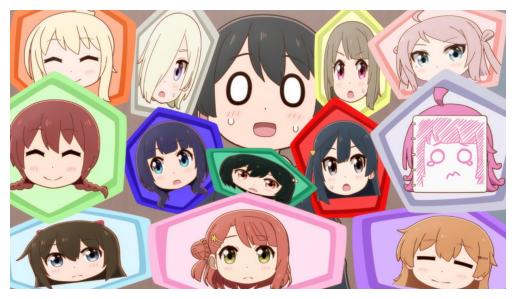

torch.Size([3, 675, 1200])

In [6]:
show_image(image_tensor)
image_tensor.size()

### (2) 產生key
這裡我想以侑的頭當成key，因此可以直接去調整load_and_crop_image()裡面left,top,right,bottom的數字去把頭取下來。因此我們需要一個可以切割圖片的函式。

In [7]:
def load_and_crop_image(image_path, crop_size):
    # Load the image
    image = Image.open(image_path)

    # Determine the size to crop the image to a square
    width, height = image.size
    min_dim = min(width, height)

    # Crop the image to the desired size
    left = ((width - min_dim) / 4)+300
    top = ((height - min_dim) / 4)
    right = ((width + min_dim) / 4)+300
    bottom = ((height + min_dim) / 4)
    image = image.crop((left, top, right, bottom))

    # Resize the image to the specified crop size
    image = image.resize((crop_size, crop_size))

    # Convert the image to a PyTorch tensor and normalize it to [0, 1]
    transform = transforms.ToTensor()
    image_tensor = transform(image)

    return image_tensor

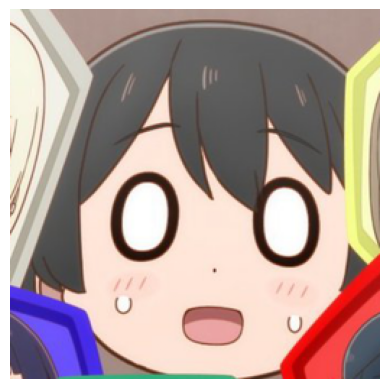

torch.Size([3, 256, 256])

In [8]:
# Example usage:
crop_size = 256  # Desired size for the cropped square image
crop_image_tensor = load_and_crop_image(image_path, crop_size)
show_image(crop_image_tensor)
crop_image_tensor.size()

接著將切下來的圖片利用複製貼上和Padding使其大小與原本的圖片相同，以此產生key $\mathbf{K}$。將此過程寫成一個函式來處理。

In [9]:
def pad_to_original_size(image_tensor, original_width, original_height):
    # Calculate the number of tiles needed
    num_tiles_width = (original_width // image_tensor.shape[2]) + 1
    num_tiles_height = (original_height // image_tensor.shape[1]) + 1

    # Create the tiled image by repeating the cropped image
    tiled_image = image_tensor.repeat(1, num_tiles_height, num_tiles_width)

    # Crop to the original size
    padded_image = tiled_image[:, :original_height, :original_width]
    
    # Calculate the padding dimensions
    pad_width = original_width - padded_image.shape[2]
    pad_height = original_height - padded_image.shape[1]

    # Pad the image
    padded_image = torch.nn.functional.pad(padded_image, 
                                           (0, pad_width, 0, pad_height), 
                                           mode='replicate')


    return padded_image

Padded image tensor shape: torch.Size([3, 675, 1200])


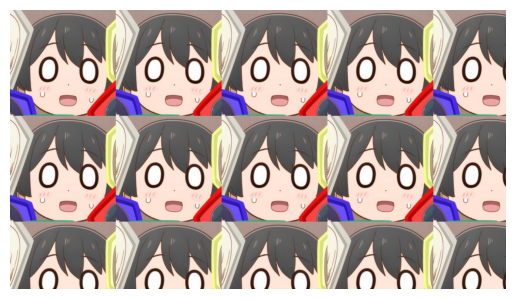

In [10]:
# Pad the cropped image to the original size
Q_width, Q_height = image.size
padded_image_tensor = pad_to_original_size(crop_image_tensor, Q_width, Q_height)

print(f"Padded image tensor shape: {padded_image_tensor.shape}")  # Should be [3, original_height, original_width]

# Show the padded image
show_image(padded_image_tensor)

### (3) 產生value
就是讀取一張新圖片而已。

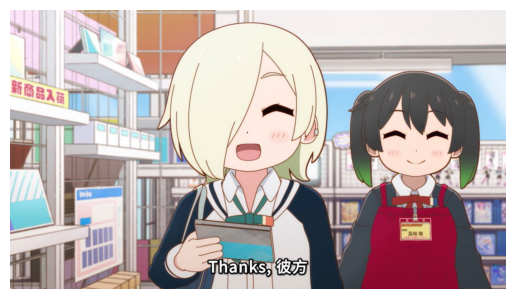

torch.Size([3, 675, 1200])

In [11]:
value_image = Image.open('value.jpg')
value_image_tensor = transform(value_image) # Convert the image to a PyTorch tensor and normalize it to [0, 1]
show_image(value_image_tensor)
value_image_tensor.size()

### (4) 計算attention map與attention weight並可視化

In [12]:
query = image_tensor
key = padded_image_tensor
value = value_image_tensor

In [13]:
heat_map, attention_weight = scaled_dot_product_attention(query, key, value, dropout_p=0.1)

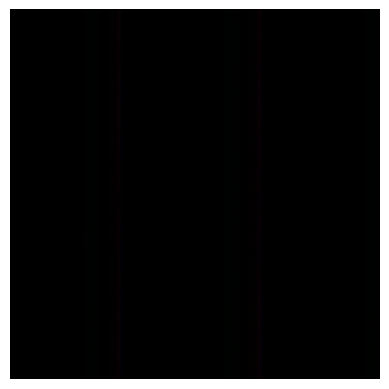

In [14]:
show_image(attention_weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


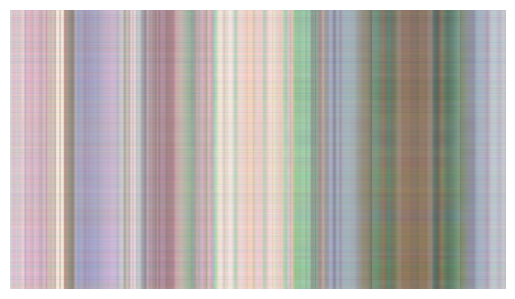

In [15]:
show_image(heat_map)

## 2. Self-attention

當$\mathbf{Q}=\mathbf{K}=\mathbf{V}$的時候，就稱為self-attention。我們用時間序列隨機生成一個張量，模擬自然語言經過encoding之後的特徵。以下是產生隨機序列的函式。

In [16]:
def generate_time_series(num_samples, sequence_length, num_variates):
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate 3 different time series
    time_series = []

    for _ in range(num_samples):
        # Generate random frequencies for each variate
        frequencies = torch.rand(num_variates) * 0.1 + 0.01

        # Generate time steps
        t = torch.linspace(0, 10, sequence_length)

        # Generate the time series for each variate
        series = torch.zeros(sequence_length, num_variates)
        for i in range(num_variates):
            amplitude = torch.rand(1).item() * 5 + 1
            phase = torch.rand(1).item() * 2 * np.pi
            trend = torch.linspace(0, torch.rand(1).item(), sequence_length)
            noise = torch.randn(sequence_length) * 0.1

            series[:, i] = amplitude * torch.sin(2 * np.pi * frequencies[i] * t + phase) + trend + noise

        time_series.append(series)

    return torch.stack(time_series)

### (1) 以自然語言的模擬為例
我們可以時間序列來模擬自然語言中一個句子中每個詞經編碼後而成的張量。

In [17]:
num_samples = 1 # 一句話
sequence_length = 5 # 這句話有五個token
num_variates = 3 # 每個token的embedding有三個分量

generated_data = generate_time_series(num_samples, sequence_length, num_variates)

print("Generated data shape:", generated_data.shape)
print(generated_data[:, :, :])

Generated data shape: torch.Size([1, 5, 3])
tensor([[[ 3.7979, -1.6929, -0.1767],
         [-4.1825, -1.6596,  0.5527],
         [-3.8719,  1.8562,  0.9264],
         [ 4.6407,  1.7788,  0.9307],
         [ 4.7957, -1.4390,  0.6234]]])


In [18]:
query = generated_data
key = generated_data
value = generated_data

In [19]:
heat_map, attention_weight = scaled_dot_product_attention(query, key, value, dropout_p=0.1)

In [20]:
print(heat_map)

tensor([[[ 5.1784, -1.5464,  0.5842],
         [-4.6411, -1.7736,  0.6216],
         [-4.3147,  1.9198,  1.0142],
         [ 5.1626,  1.8097,  1.0169],
         [ 5.2623, -1.4518,  0.6612]]])


In [21]:
print(attention_weight)

tensor([[[1.4616e-01, 0.0000e+00, 0.0000e+00, 2.7843e-02, 9.3711e-01],
         [3.8138e-09, 1.0911e+00, 1.9997e-02, 2.5489e-11, 3.4686e-10],
         [4.7352e-10, 4.0556e-02, 1.0706e+00, 5.3719e-09, 1.0248e-10],
         [1.7281e-03, 1.3698e-12, 1.4234e-10, 1.0594e+00, 4.9954e-02],
         [5.8573e-02, 1.8772e-11, 0.0000e+00, 5.0308e-02, 1.0022e+00]]])


Output的維度為$10\times512$，與$\mathbf{Q}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

### (2) 以圖片為例

In [22]:
heat_map, attention_weight = scaled_dot_product_attention(image_tensor, image_tensor, image_tensor, dropout_p=0.1)

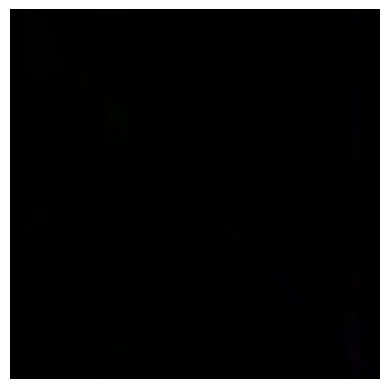

In [23]:
show_image(attention_weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


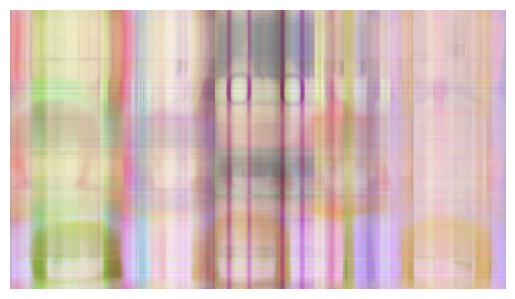

In [24]:
show_image(heat_map)

## 3. Multi-head Attention

![jupyter](./mha_img_original.png)
![jupyter](./multihead.png)

如果$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，得到$\mathbf{Q}_1,...,\mathbf{Q}_h$, $\mathbf{K}_1,...,\mathbf{K}_h$, $\mathbf{V}_1,...,\mathbf{V}_h$。那麼我們可以將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做attention。具體的方法是：
1. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別過一個linear layer
2. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，
3. 將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做Scaled Dot-Product attention
4. 將output出來的heat map接起來
5. 最後過一個linear layer得到output。
此過程就稱為稱為$h$-head之multi-head attention。

此方法亦可推廣到self-attention的情形。考慮自然語言的情形。當一句話有$N$個token，且每個token的embedding，比方說，都有512個分量。此時我們可以將這512個分量分組，比方說分成8組(稱為8 head)，每組64個分量。這樣一來，一句話的特徵本來是一個$N\times512$的張量$\mathbf{B}$，就被我們拆解成了8個$N\times64$的張量$\mathbf{B}_1,...,\mathbf{B}_8$。把這八個張量分別先過一個linear layer，再做self attention，得到8張heat map。我們可以說這代表8種自然語言中implicit的知識。最後，再將這8個heat map接起來並通過一個linear layer就算出Multi-head Attention了。

使用scaled_dot_product_attention()來做出multi-head attention。這裡用到view()這個函數，可以將tensor做resize。我們可以用這個方法來做multi-head切割。注意到linear layer是需要被訓練的。

In [25]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module 
        Credit: https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/SubLayers.py
    '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        ''' args:
            n_head: N head
            d_model: Output layer size and the initial embedding size of Q (as well as K and V here, in seld-attention context)
            d_k dimension of the key K
            d_v: dimension of the value V
        '''
        
        # args
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        
        # The paper asks to linearly project the queries, keys and values h times with different, 
        # learned linear projections to dk, dk and dv dimensions, respectively.
        self.Q_linear = nn.Linear(d_model, n_head * d_k, bias=False)
        self.K_linear = nn.Linear(d_model, n_head * d_k, bias=False)
        self.V_linear = nn.Linear(d_model, n_head * d_v, bias=False)
        
        # Output layer
        self.out = nn.Linear(n_head * d_v, d_model, bias=False)

    def forward(self, q, k, v, mask=None):
        
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        dropout_p = self.dropout

        # Linear projections
        q = self.Q_linear(q).view(sz_b, len_q, n_head, d_k)
        k = self.K_linear(k).view(sz_b, len_k, n_head, d_k)
        v = self.V_linear(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        q, attention_weight = scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)

        return q, attention_weight

### (1) 以自然語言的模擬為例

現假設$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別為三個句子經編碼後而成的張量，每個句子有10個token，每個token的embedding的長度為d_model。建立multi-head attention的物件並將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$三個句子送入其中，並使用8 head來做計算。

In [26]:
# Define the parameters
n_head = 8
d_model = 512
d_k = 64
d_v = 64
dropout = 0.1

# Initialize the MultiHeadAttention module
multi_head_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout)

In [27]:
# Create example tensors Q, K, and V with batch size
batch_size = 1 # Q, K, V分別有幾個句子
sequence_length = 10

Q = torch.rand(batch_size, sequence_length, d_model)
K = torch.rand(batch_size, sequence_length, d_model)
V = torch.rand(batch_size, sequence_length, d_model)

In [28]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = multi_head_attention(Q, K, V)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 10, 512])
Attention weights shape: torch.Size([1, 8, 10, 10])


Output的維度為$10\times512$，與$\mathbf{Q}, \mathbf{K}, \mathbf{V}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

### (2) 以圖片為例
$\mathbf{Q}, \mathbf{K}, \mathbf{V}\in\mathbb{R}^{3\times w \times h}$分別為三張圖片。每張圖片都有R,G,B三個channel，圖片的長寬分別為$h,w$。為了塞進去，我們可以將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [29]:
batch_size = 1 # Q, K, V分別有幾張圖片
c, w, h = image_tensor.size()

Q = image_tensor.view(batch_size, w*c, h)
K = padded_image_tensor.view(batch_size, w*c, h)
V = value_image_tensor.view(batch_size, w*c, h)

In [30]:
print(Q.size(), K.size(), V.size())

torch.Size([1, 2025, 1200]) torch.Size([1, 2025, 1200]) torch.Size([1, 2025, 1200])


In [31]:
# Define the parameters
n_head = 8
d_model = Q.size()[-1]  # Adjust d_model to match the input tensor's last dimension or projected dimension
d_k = d_model // n_head
d_v = d_model // n_head
dropout = 0.1

# Initialize the MultiHeadAttention module
multi_head_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout)

In [32]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = multi_head_attention(Q, K, V)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 2025, 1200])
Attention weights shape: torch.Size([1, 8, 2025, 2025])


算出來的結果要處理一下才有辦法看

In [33]:
output_img = output.view(c, w, h).detach()

In [34]:
# Find the minimum and maximum values in the tensor
min_val = torch.min(output_img)
max_val = torch.max(output_img)

# Apply min-max normalization
output_img = (output_img - min_val) / (max_val - min_val)

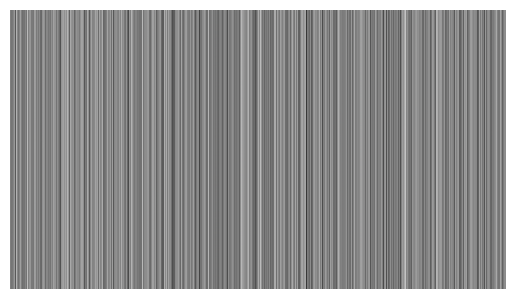

In [35]:
show_image(output_img)

# 二. Transformer的Encoder

## 1. Transformer的Encoder Block
這是Encoder block的樣子。就把東西串一串就接出來了。

![jupyter](./encoder_block.png)

每一個encoder block分為上下兩個sub-layer。
1. Lower sub-layer: 由Multi-head Attention與Add&Norm組成。Add&Norm是將Multi-head Attention的input與output相加後做layer normalization。
2. Upper sub-layer: 由數個fully connected layer與Add&Norm組成。Add&Norm會將Lower sublayer的input以及fully connected layer的output相加後做layer normalization。
此外原論文也提到，每個sublayer在做Add&Norm都有先接一個dropout。

將input和output加起來的手法稱為residual connection，其目的為

做layer normalization的目的是為了防止數值爆掉結果算不了梯度。此外，每個encoder block都可以當成一個度規空間。下一層block所代表的度規空間，其物理意義可能與上一層差很多，因此upper sub-layer用fully connected layer代表進行一個非線性的變換，用以連接兩個block。

In [36]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        ''' args:
            n_head: N head
            d_model: Output layer size and the initial embedding size of Q (as well as K and V here, in seld-attention context)
            d_inner: The size of fully connected layer in upper sub-layer. Since we only have one 
            d_k dimension of the key K
            d_v: dimension of the value V
        '''
        super(EncoderLayer, self).__init__()
        
        # Lower sub-layer
        self.self_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.dropout_lower = nn.Dropout(dropout)
        self.layer_norm_lower = nn.LayerNorm(d_model, eps=1e-6)
        
        # Upper sub-layer
        self.FCN1 = nn.Linear(d_model, d_inner)
        self.FCN2 = nn.Linear(d_inner, d_model)
        self.dropout_upper = nn.Dropout(dropout)
        self.layer_norm_upper = nn.LayerNorm(d_model, eps=1e-6)     

    def forward(self, encoder_layer_input, mask=None):
        ''' return values:
            x: the encoder layer output
            encoder_layer_attention_weights: multi-head attention map
        '''
        
        # Lower sub-layer
        residual = encoder_layer_input
        x, encoder_layer_attention_weights = self.self_attention(encoder_layer_input, 
                                                                 encoder_layer_input, 
                                                                 encoder_layer_input,
                                                                 mask=mask)
        x = self.dropout_lower(x)
        x = x + residual
        x = self.layer_norm_lower(x)
        
        # Upper sub-layer
        residual = x
        x = F.relu(self.FCN1(x))
        x = F.relu(self.FCN2(x))
        x = self.dropout_upper(x)
        x = x + residual
        x = self.layer_norm_upper(x)

        return x, encoder_layer_attention_weights

### (1) 以自然語言的模擬為例
模仿之前的例子，假設$\mathbf{Q}$為一個自然語言的句子經編碼後而成的張量，此句子有10個token，每個token的embedding的長度為d_model。設$d_\text{model}$為512。

In [37]:
# Define the parameters
n_head = 8
d_model = 512
d_inner = 128
d_k = 64
d_v = 64
dropout = 0.1

# Initialize the MultiHeadAttention module
encoder_layer = EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout)

In [38]:
# Create example tensors Q with batch size
batch_size = 1 # Q, K, V分別有幾個句子
sequence_length = 10

Q = torch.rand(batch_size, sequence_length, d_model)

In [39]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = encoder_layer(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 10, 512])
Attention weights shape: torch.Size([1, 8, 10, 10])


### (2) 以圖片為例
一樣模仿之前的例子。設$\mathbf{Q}\in\mathbb{R}^{3\times w \times h}$為一張有R,G,B三個channel的圖片，其長寬分別為$h,w$。將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [40]:
batch_size = 1 # 一個batch有幾張圖片
c, w, h = image_tensor.size()
Q = image_tensor.view(batch_size, w*c, h)

In [41]:
# Define the parameters
n_head = 8
d_model = Q.size()[-1]  # Adjust d_model to match the input tensor's last dimension or projected dimension
d_inner = 300
d_k = d_model // n_head
d_v = d_model // n_head
dropout = 0.1

# Initialize the MultiHeadAttention module
encoder_layer = EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout)

In [42]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = encoder_layer(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 2025, 1200])
Attention weights shape: torch.Size([1, 8, 2025, 2025])


In [43]:
output_img = output.view(c, w, h).detach()

# Find the minimum and maximum values in the tensor
min_val = torch.min(output_img)
max_val = torch.max(output_img)

# Apply min-max normalization
output_img = (output_img - min_val) / (max_val - min_val)

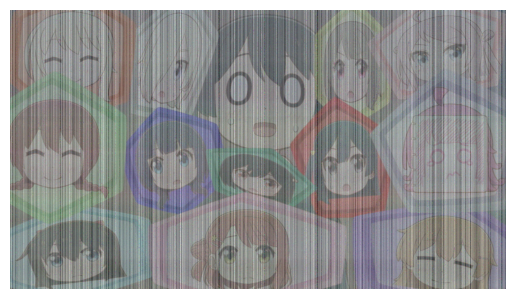

In [44]:
show_image(output_img)

## 2. Positional Encoding

Positional Encoding的物理意義是為模型提供與"位置"有關的訊息。因為Encoder block不像RNN有先後關係，也不像CNN反映空間頻率，因此需要另外添加關於每個單詞所在位置的編碼。論文中所用的編碼方式如下：
$$\Large{\text{PE}(\text{pos}, 2i) = \sin\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$
$$\Large{\text{PE}(\text{pos}, 2i+1) = \cos\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$

所產生的位置編碼$\mathbf{x}\in\mathbb{R}^{d_\text{model}}$，並將此embedding直接加到input data的embedding之中（雖然聽起來應該要接起來才好，但這招確實有用）。這麼做的物理意義是，因為單字經過編碼後，意義相近的單字更接近。而當位置更相近時，相同的單字更可能有相同的意義，因此才將兩種embedding直接相加。

In [45]:
def positional_encoding(length, depth):
    depth = depth // 2
    positions = torch.arange(length, dtype=torch.float).unsqueeze(1)  # (length, 1)
    depths = torch.arange(depth, dtype=torch.float).unsqueeze(0) / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    pos_encoding = torch.cat([torch.sin(angle_rads), torch.cos(angle_rads)], dim=-1)
    pos_encoding = pos_encoding.unsqueeze(0)  # Add batch dimension
    return pos_encoding

In [46]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, d_model):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        #self.embedding = nn.Embedding(sequence_length, d_model)
        self.pos_encoding = positional_encoding(length=sequence_length, depth=d_model)

    def forward(self, x):
        length = x.size(1)
        #x = self.embedding(x) # Require all the data to be int64, so we turn of it here
        x *= math.sqrt(self.d_model)  # This factor sets the relative scale of the embedding and positional_encoding.
        x = x + self.pos_encoding[:, :length, :].to(x.device)
        return x

實際畫一下，感受position經過encoding出來是什麼東西。以下模擬一個長2048個token的句子，每一個token由$d_\text{model}=512$維的向量所編碼。

torch.Size([2048, 512])


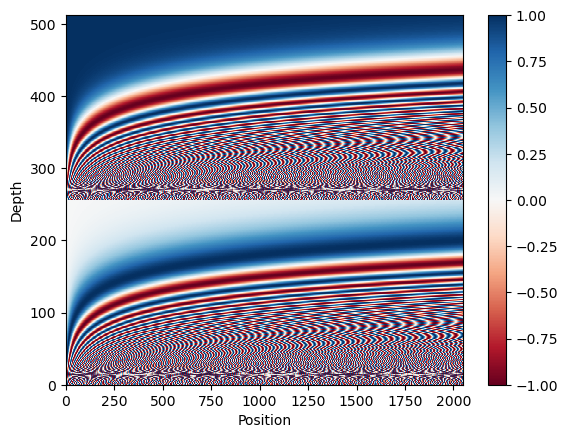

In [47]:
pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding[0].shape)
plt.pcolormesh(pos_encoding[0].numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

因為torch.norm()的計算方式的關係，下圖畫出來會跟Tensorflow的版本不大一樣。

(0.0, 1.0)

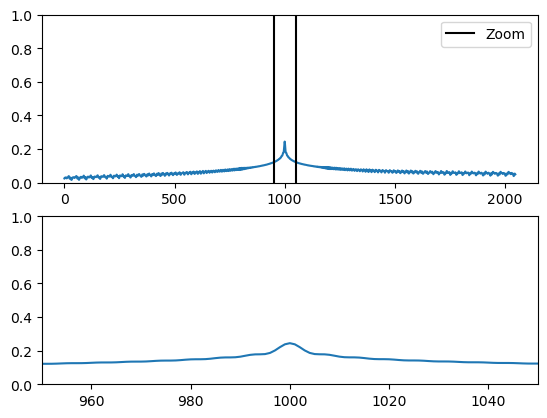

In [48]:
pos_encoding = pos_encoding / torch.norm(pos_encoding, dim=1, keepdim=True)
p = pos_encoding[0][1000]
dots = torch.einsum('pd,d->p', pos_encoding[0], p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

## 3. Encoder的建立
每一個Encoder都可以有很多個Layer，因此我們的Encoder在設計的時候也要能夠讓使用者自行決定層數。一般而言會把層數設在6，12，18...，不過資料不夠多的時候可以適當縮小之。

In [49]:
class Encoder(nn.Module):
    def __init__(self, n_src_vocab, num_layers, d_model, pad_idx, num_heads, d_inner, 
                 sequence_length, dropout_rate=0.1, n_position=200, scale_emb=False):
        super(Encoder, self).__init__()
        ''' args:
            n_src_vocab: Size of the source vocabulary
            pad_idx: Padding index
            num_layers: How many layers should this model have
            d_model: The dimension of the output embedding
            num_heads: Number of attention heads
            d_inner: The number of units in the fully connected networks (FCNs) of each layer
            sequence_length: The length of the input sequences
            dropout_rate: The dropout rate of each dropout layer in the model
            n_position: The number of positions for positional encoding
            scale_emb: Whether to scale the embeddings
        '''
        self.d_model = d_model
        self.num_layers = num_layers
        self.scale_emb = scale_emb
        self.src_word_emb = nn.Embedding(n_src_vocab, sequence_length, padding_idx=pad_idx)
        
        self.pos_embedding = PositionalEmbedding(sequence_length=n_position, d_model=d_model)
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model=d_model, 
                                                      d_inner=d_inner, 
                                                      n_head=num_heads, 
                                                      d_k=d_model//num_heads, 
                                                      d_v=d_model//num_heads, 
                                                      dropout=dropout_rate)
                                         for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src_seq, src_mask, return_attns=False, mask=None):
        enc_slf_attn_list = []

        # -- Forward
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.pos_embedding(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.enc_layers:
            enc_output, enc_slf_attn = enc_layer(enc_output, mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
        
        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,

### (1) 以自然語言的模擬為例

In [50]:
# Test class for the Encoder
def test_encoder():
    # Parameters
    n_src_vocab = 10000    # Size of the source vocabulary
    num_layers = 6         # Number of layers in the encoder
    d_model = 512          # Dimension of the model
    pad_idx = 0            # Padding index
    num_heads = 8          # Number of attention heads
    d_inner = 2048         # Inner layer dimension
    sequence_length = 512  # Sequence length (dimension of each input instance)
    dropout_rate = 0.1     # Dropout rate
    n_position = 200       # Number of positions for positional encoding
    scale_emb = False      # Whether to scale embeddings

    # Create an encoder instance
    encoder = Encoder(n_src_vocab, num_layers, d_model, pad_idx, num_heads, d_inner, 
                      sequence_length, dropout_rate, n_position, scale_emb)

    # Create some example input data
    batch_size = 32
    src_seq_len = 20

    src_seq = torch.randint(0, n_src_vocab, (batch_size, src_seq_len)).long()  # Source sequence
    src_mask = torch.ones(batch_size, src_seq_len, src_seq_len).bool()  # Source mask

    # Run the forward pass
    enc_output, = encoder(src_seq, src_mask, return_attns=False)

    # Check the output shape
    assert enc_output.shape == (batch_size, src_seq_len, d_model), \
    f"Expected shape: {(batch_size, src_seq_len, d_model)}, but got: {enc_output.shape}"

    print("Encoder forward pass successful. Output shape:", enc_output.shape)

# Run the test
test_encoder()

Encoder forward pass successful. Output shape: torch.Size([32, 20, 512])


### (2) 以圖片為例
一樣模仿之前的例子。設$\mathbf{Q}\in\mathbb{R}^{3\times w \times h}$為一張有R,G,B三個channel的圖片，其長寬分別為$h,w$。將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [51]:
batch_size = 1 # 一個batch有幾張圖片
resize_transform = transforms.Resize((27,48)) # 圖片太大了要先縮放
image_tensor_resize =  resize_transform(image_tensor.unsqueeze(0)).squeeze(0)
c, w, h = image_tensor_resize.size()
Q = ((image_tensor_resize.view(batch_size, h*w*c))*1000).long()

In [52]:
# Parameters for the Encoder
n_src_vocab = 1000    # Size of the source vocabulary
num_layers = 1         # Number of layers in the encoder
d_model = h*w*c        # Ensure d_model matches the reshaped height
pad_idx = 0            # Padding index
num_heads = 2          # Number of attention heads
d_inner = 128         # Inner layer dimension
sequence_length = h*w*c  # Sequence length (dimension of each input instance)
dropout_rate = 0.1     # Dropout rate
n_position = h*w*c       # Number of positions for positional encoding
scale_emb = False      # Whether to scale embeddings

# Create an encoder instance
encoder = Encoder(n_src_vocab, num_layers, d_model, pad_idx, num_heads, d_inner, 
                  sequence_length, dropout_rate, n_position, scale_emb)

In [53]:
# Create a source mask (for simplicity, using an identity mask here)
src_mask = torch.ones(batch_size, sequence_length, sequence_length).bool()

# Run the forward pass with the reshaped image tensor
enc_output, = encoder(Q, src_mask, return_attns=False)

# Check the output shape
print(f"Encoder output shape: {enc_output.shape}")  # Should print [batch_size, seq_len, d_model]

Encoder output shape: torch.Size([1, 3888, 3888])


# 三. Transformer的Decoder

## 1. Decoder Block

![jupyter](./decoder_block.png)

Decoder block由三個sublayer組成。然而，其中的Add Norm，Feed forward和residual我們都已經實作過了。不過，Decoder的multi-head attention會和encoder有些許不同。如同encoder，由下到上，decoder layer可分為三個sublayer。
1. The causal self-attention layer
2. Cross attention layer
3. Feed forward layer: 跟encoder一樣

### (1) The causal self-attention layer
最底下的Masked Multi-Head Attention又稱為causal self-attention layer。其物理意義為我們希望某一位置（時刻）的output只與其之前的位置（時刻）的輸入有關。就好比訊號與系統中的causal system。這麼做的好處有三：
1. 訓練上更有效率：因為只需考慮該位置之前的input
2. 該位置的output可以供下一個位置的output做使用

![jupyter](./causalattention.png)

### (2) Cross Attention Layer
Decoder layer中間的multi-head attention又稱為cross attention。它就是普通的multi-head attention，不過它以encoder的output為queue和key，並以causal self-attention layer的output為value。

### (3) Feed-forward

In [54]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

### (4) Decoder Layer的架設

In [55]:
class DecoderLayer(nn.Module):
    ''' Compose with three layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        ''' args:
            d_model: The dimension of the output embedding
            d_inner: The number of units in the FCNs of each layer
            n_head: number of heads
            d_k dimension of the key K
            d_v: dimension of the value V
            dropout_rate: The dropout rate of each dropout layer in the model
            num_layers: How many layers should this model have      
        '''
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layer_norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        residual = dec_input

        dec_output, dec_slf_attn = self.slf_attn(dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output = self.dropout1(dec_output)
        dec_output = dec_output + residual
        dec_output = self.layer_norm1(dec_output)
        
        residual = dec_output

        dec_output, dec_enc_attn = self.enc_attn(q=dec_output, k=enc_output, v=enc_output, mask=dec_enc_attn_mask)
        dec_output = self.dropout2(dec_output)
        dec_output = dec_output + residual
        dec_output = self.layer_norm2(dec_output)
        
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

## 2. Decoder的架設

![jupyter](./decoder.png)

Decoder的結構為：
1. input會先經過一個embedding（稱為output embedding）
2. Positional Encoding
3. 數個decoder layer疊起來

直接按照圖片將其串起來。

In [56]:
class Decoder(nn.Module):
    ''' A decoder model with self attention mechanism. '''

    def __init__(self, n_trg_vocab, d_word_vec, n_layers, n_head, d_model, d_inner, 
                 pad_idx, n_position=200, dropout=0.1, scale_emb=False):
        super().__init__()
        ''' args:
            n_trg_vocab: size of the dictionary of embeddings
            d_word_vec: sequence_length of Encoder. The dimension of the embedding of each input instance 
            n_layers: How many layers should this model have
            n_head: number of heads
            d_model: The dimension of the output embedding
            d_inner: The number of units in the FCNs of each layer
            n_position: The number of positions for positional encoding
            pad_idx: Padding index
            dropout_rate: The dropout rate of each dropout layer in the model
            scale_emb: Whether to scale the embeddings
        '''
        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEmbedding(sequence_length=n_position, d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([DecoderLayer(d_model=d_model, 
                                                       d_inner=d_inner, 
                                                       n_head=n_head, 
                                                       d_k=d_model//n_head, 
                                                       d_v=d_model//n_head, 
                                                       dropout=dropout)
                                          for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, enc_output, trg_mask=None, src_mask=None, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        
        # -- Forward
        dec_output = self.trg_word_emb(trg_seq)
        
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(dec_input=dec_output, 
                                                               enc_output=enc_output, 
                                                               slf_attn_mask=trg_mask, 
                                                               dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
        
        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,

測試一下。

In [57]:
# Test class for the Decoder
def test_decoder():
    # Parameters
    n_trg_vocab = 10000   # Size of the target vocabulary
    d_word_vec = 512      # Word embedding size
    n_layers = 6          # Number of layers in the decoder
    n_head = 8            # Number of attention heads
    d_model = 512         # Dimension of the model
    d_inner = 2048        # Inner layer dimension
    pad_idx = 0           # Padding index
    dropout = 0.1         # Dropout rate
    scale_emb = False     # Whether to scale embeddings

    # Create a decoder instance
    decoder = Decoder(n_trg_vocab, d_word_vec, n_layers, n_head, d_model, d_inner, pad_idx, dropout, scale_emb)

    # Create some example input data
    batch_size = 32
    trg_seq_len = 20
    src_seq_len = 20

    trg_seq = torch.randint(0, n_trg_vocab, (batch_size, trg_seq_len)).long()  # Target sequence
    enc_output = torch.randn(batch_size, src_seq_len, d_model)  # Encoder output
    trg_mask = torch.ones(batch_size, trg_seq_len, trg_seq_len).bool()  # Target mask
    src_mask = torch.ones(batch_size, trg_seq_len, src_seq_len).bool()  # Source mask
    print(trg_mask.size(), src_mask.size())

    # Run the forward pass
    dec_output, = decoder(trg_seq, enc_output, trg_mask, src_mask, return_attns=False)

    # Check the output shape
    assert dec_output.shape == (batch_size, trg_seq_len, d_model), f"Expected shape: \
    {(batch_size, trg_seq_len, d_model)}, but got: {dec_output.shape}"

    print("Decoder forward pass successful. Output shape:", dec_output.shape)

# Run the test
test_decoder()

torch.Size([32, 20, 20]) torch.Size([32, 20, 20])
Decoder forward pass successful. Output shape: torch.Size([32, 20, 512])


# 四. Transformer的搭建

![jupyter](./transformer.png)

至此我們可以搭建整個transformer了。注意到藍色框框內的東西我們已經做好了，因此實作的時候直接調用前面的定義的class。別忘了最後還有一個dense layer跟softmax。

## 1. 模型的整體架構

In [58]:
# Define helper functions to create masks
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

In [59]:
class Transformer(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''

    def __init__(self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
                 d_word_vec=512, d_model=512, d_inner=2048,
                 n_layers=6, n_head=8, dropout=0.1, n_position=200,
                 trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
                 scale_emb_or_prj='prj'):
        super().__init__()
        ''' args:
            n_src_vocab: Size of the source vocabulary
            n_trg_vocab: Size of the target vocabulary
            src_pad_idx: Padding index for the source sequences
            trg_pad_idx: Padding index for the target sequences
            d_word_vec: Dimensionality of the word embeddings
            d_model: Dimension of the model (must be the same as d_word_vec to facilitate residual connections)
            d_inner: Number of units in the inner feed-forward layers
            n_layers: Number of layers in the encoder and decoder
            n_head: Number of attention heads
            dropout: Dropout rate for regularization
            n_position: Number of positions for positional encoding
            trg_emb_prj_weight_sharing: Whether to share the weight matrix between target word embedding 
                                        & the pre-softmax linear transformation
            emb_src_trg_weight_sharing: Whether to share the weight matrix between source and target word embeddings
            scale_emb_or_prj: Scaling method to apply ('emb', 'prj', or 'none')
        '''
        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        # In section 3.4 of paper "Attention Is All You Need", there is such detail:
        # "In our model, we share the same weight matrix between the two
        # embedding layers and the pre-softmax linear transformation...
        # In the embedding layers, we multiply those weights by \sqrt{d_model}".
        #
        # Options here:
        #   'emb': multiply \sqrt{d_model} to embedding output
        #   'prj': multiply (\sqrt{d_model} ^ -1) to linear projection output
        #   'none': no multiplication

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(n_src_vocab=n_src_vocab, 
                               n_position=n_position,
                               sequence_length=d_word_vec, 
                               d_model=d_model, 
                               d_inner=d_inner,
                               num_layers=n_layers, 
                               num_heads=n_head, 
                               pad_idx=src_pad_idx, 
                               dropout_rate=dropout, 
                               scale_emb=scale_emb)

        self.decoder = Decoder(n_trg_vocab=n_trg_vocab, 
                               n_position=n_position,
                               d_word_vec=d_word_vec, 
                               d_model=d_model, 
                               d_inner=d_inner,
                               n_layers=n_layers, 
                               n_head=n_head, 
                               pad_idx=trg_pad_idx, 
                               dropout=dropout, 
                               scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 
        
        #To facilitate the residual connections, the dimensions of all module outputs shall be the same.
        assert d_model == d_word_vec
        
        if trg_emb_prj_weight_sharing:
            # Share the weight between target word embedding & last dense layer
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):
        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, *_ = self.encoder(src_seq=src_seq, src_mask=src_mask)
        dec_output, *_ = self.decoder(trg_seq=trg_seq, enc_output=enc_output, trg_mask=trg_mask, src_mask=src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5
        seq_logit = torch.softmax(seq_logit, dim=-1)
        
        return seq_logit.view(-1, seq_logit.size(2))

我們來搭建一個encoder和decoder都各四層的transformer。它的dataflow如下圖所示：

![jupyter](./Transformer-4layer-compact.png)

In [60]:
# Parameters for the Transformer
n_src_vocab = 10000
n_trg_vocab = 10000
src_pad_idx = 0
trg_pad_idx = 0
d_word_vec = 512
d_model = 512
d_inner = 2048
n_layers = 1
n_head = 8
dropout = 0.1
n_position = 200
trg_emb_prj_weight_sharing = True
emb_src_trg_weight_sharing = True
scale_emb_or_prj = 'prj'

In [61]:
# Create the Transformer instance
transformer = Transformer(
    n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
    d_word_vec, d_model, d_inner, n_layers, n_head,
    dropout, n_position, trg_emb_prj_weight_sharing,
    emb_src_trg_weight_sharing, scale_emb_or_prj
)

In [62]:
# Create some example input data
batch_size = 32
src_seq_len = 20
trg_seq_len = 20

src_seq = torch.randint(0, n_src_vocab, (batch_size, src_seq_len)).long()
trg_seq = torch.randint(0, n_trg_vocab, (batch_size, trg_seq_len)).long()

# Run the forward pass
seq_logit = transformer(src_seq, trg_seq)

# Check the output shape
expected_shape = (batch_size * trg_seq_len, n_trg_vocab)
assert seq_logit.shape == expected_shape, f"Expected shape: {expected_shape}, but got: {seq_logit.shape}"

print("Transformer forward pass successful. Output shape:", seq_logit.shape)

Transformer forward pass successful. Output shape: torch.Size([640, 10000])


最後來看看這個transformer的一些資訊：

In [63]:
summary(transformer)

Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─Embedding: 2-1                              5,120,000
|    └─PositionalEmbedding: 2-2                    --
|    └─ModuleList: 2-3                             --
|    |    └─EncoderLayer: 3-1                      3,150,336
|    └─LayerNorm: 2-4                              1,024
|    └─Dropout: 2-5                                --
├─Decoder: 1-2                                     --
|    └─Embedding: 2-6                              5,120,000
|    └─PositionalEmbedding: 2-7                    --
|    └─Dropout: 2-8                                --
|    └─ModuleList: 2-9                             --
|    |    └─DecoderLayer: 3-2                      4,199,936
|    └─LayerNorm: 2-10                             1,024
├─Linear: 1-3                                      5,120,000
Total params: 22,712,320
Trainable params: 22,712,320
Non-trainable params: 0


Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─Embedding: 2-1                              5,120,000
|    └─PositionalEmbedding: 2-2                    --
|    └─ModuleList: 2-3                             --
|    |    └─EncoderLayer: 3-1                      3,150,336
|    └─LayerNorm: 2-4                              1,024
|    └─Dropout: 2-5                                --
├─Decoder: 1-2                                     --
|    └─Embedding: 2-6                              5,120,000
|    └─PositionalEmbedding: 2-7                    --
|    └─Dropout: 2-8                                --
|    └─ModuleList: 2-9                             --
|    |    └─DecoderLayer: 3-2                      4,199,936
|    └─LayerNorm: 2-10                             1,024
├─Linear: 1-3                                      5,120,000
Total params: 22,712,320
Trainable params: 22,712,320
Non-trainable params: 0

In [64]:
del transformer, src_seq, trg_seq

## 2. Optimizer與Learning Rate
原本的paper推薦使用Adam搭配以下的learning rate公式：

$$\Large{\text{learning rate} = d_\text{model}^{-0.5} \times \min(\text{step\_num}^{-0.5}, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5})}$$

learning rate與epoch次數有關。在前`warmup_steps`個epoch中learning rate會線性上升，之後下降。

In [65]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## 3. Loss與Metric
訓練的時候的target sequences可能有經過padding，因此需要定義一個用來算accuracyc和loss的mask。否則會看到一大堆padding所造成的錯誤率。

In [66]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):
    ''' Apply label smoothing if needed '''

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word

In [67]:
def cal_loss(pred, gold, trg_pad_idx, smoothing=False):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss

# 五. Transformer的訓練－以機器翻譯為例
來做一個把德語翻成英文的機器

## 1. Dataset的準備
以下都是一些dirty work。這裡做的事情跟transformer一點關係都沒有。

### (1) 引入mtnt翻譯資料集

In [68]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

In [69]:
train_en = load_data('./data_pytorch/train.en')
train_ja = load_data('./data_pytorch/train.ja')
dev_en = load_data('./data_pytorch/dev.en')
dev_ja = load_data('./data_pytorch/dev.ja')
test_en = load_data('./data_pytorch/test.en')
test_ja = load_data('./data_pytorch/test.ja')

### (2) 用tokenizer處理資料集
下載這個日文與英文的tokenizer。

In [70]:
# Define tokenizers for Japanese and English
src_tokenizer = get_tokenizer('spacy', language='ja_core_news_sm')
trg_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [71]:
# Function to yield tokenized sentences
def yield_tokens(data, tokenizer):
    for sentence in data:
        yield tokenizer(sentence)

In [72]:
# Build vocabularies
src_vocab = build_vocab_from_iterator(yield_tokens(train_ja, src_tokenizer), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
src_vocab.set_default_index(src_vocab["<unk>"])

trg_vocab = build_vocab_from_iterator(yield_tokens(train_en, trg_tokenizer), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
trg_vocab.set_default_index(trg_vocab["<unk>"])

In [73]:
# Define constants
SRC_PAD_IDX = src_vocab["<pad>"]
TRG_PAD_IDX = trg_vocab["<pad>"]

In [74]:
def data_process(src_data, trg_data, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, max_len=128):
    data = []
    for src_sentence, trg_sentence in tqdm(zip(src_data, trg_data)):
        src_tokens = [src_vocab[token] for token in src_tokenizer(src_sentence)]
        trg_tokens = [trg_vocab[token] for token in trg_tokenizer(trg_sentence)]
        
        # Truncate sequences to max_len
        src_tokens = src_tokens[:max_len]
        trg_tokens = trg_tokens[:max_len]
        
        # Pad sequences to max_len
        src_tensor = torch.tensor(src_tokens + [src_vocab["<pad>"]] * (max_len - len(src_tokens)), dtype=torch.long)
        trg_tensor = torch.tensor(trg_tokens + [trg_vocab["<pad>"]] * (max_len - len(trg_tokens)), dtype=torch.long)
        
        data.append((src_tensor, trg_tensor))
    return data

In [76]:
# test code
train_data = data_process(train_ja, train_en, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, max_len=126)
valid_data = data_process(dev_ja, dev_en, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, max_len=126)
test_data = data_process(test_ja, test_en, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, max_len=126)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### (3) 建立training set與validatoin set的DataLoader

In [77]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_item, trg_item in batch:
        src_batch.append(torch.cat([torch.tensor([src_vocab["<bos>"]]), src_item, torch.tensor([src_vocab["<eos>"]])], dim=0))
        trg_batch.append(torch.cat([torch.tensor([trg_vocab["<bos>"]]), trg_item, torch.tensor([trg_vocab["<eos>"]])], dim=0))
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch

In [78]:
BATCH_SIZE = 16

In [79]:
train_loader = DataLoader(TranslationDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(TranslationDataset(valid_data), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(TranslationDataset(test_data), batch_size=BATCH_SIZE, collate_fn=collate_fn)

### (4) 建立訓練資料與標籤的配對
You might have expected the `input, output`, pairs to simply be the `Japanese, English` sequences.
Given the Japanese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

在訓練時，transformer的encoder將會吃以[START][END]包圍的日文句子作為輸入，decoder吃對應的[START]+英文句子作為輸入。至於訓練的標籤將會使用英文句子+[END]。換言之，就是用文字接龍的方式來訓練。如下圖所示：

![jupyter](./train.png)

我們把這樣的邏輯寫到以下function之中。

In [80]:
def train_epoch(model, training_data, optimizer, src_pad_idx, trg_pad_idx, device, smoothing):
    ''' Epoch operation in training phase '''
    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0
    desc = '  - (Training)   '

    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        # prepare data
        src_seq = batch[0].transpose(0, 1).to(device)
        trg_seq = batch[1].transpose(0, 1).to(device)
        gold = trg_seq[:,1:].contiguous().view(-1)

        # forward
        optimizer.zero_grad()
        pred = model(src_seq, trg_seq[:, :-1])
        
        # backward and update parameters
        loss, n_correct, n_word = cal_performance(pred, gold, trg_pad_idx, smoothing=smoothing) 
        loss.backward()
        optimizer.step_and_update_lr()
        
        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        
    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    
    return loss_per_word, accuracy

In [81]:
def eval_epoch(model, validation_data, device, src_pad_idx, trg_pad_idx):
    ''' Epoch operation in evaluation phase '''
    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0
    desc = '  - (Validation) '

    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):
            # prepare data
            src_seq = batch[0].transpose(0, 1).to(device)
            trg_seq = batch[1].transpose(0, 1).to(device)
            gold = trg_seq[:,1:].contiguous().view(-1)
            
            # forward
            pred = model(src_seq, trg_seq[:, :-1])
            loss, n_correct, n_word = cal_performance(pred, gold, trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()
            
    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    
    return loss_per_word, accuracy

In [82]:
def train(model, training_data, validation_data, optimizer, device, opt):
    ''' Start training '''
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')
        start = time.time()
        train_loss, train_accu = train_epoch(model, 
                                             training_data, 
                                             optimizer, 
                                             opt.src_pad_idx, 
                                             opt.trg_pad_idx, 
                                             device, 
                                             smoothing=opt.label_smoothing)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt.src_pad_idx, opt.trg_pad_idx)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

## 2. 建立模型並訓練

定義超參數並建立模型。

In [83]:
# Define options class to pass parameters
class Options:
    def __init__(self):
        self.src_pad_idx = SRC_PAD_IDX
        self.trg_pad_idx = TRG_PAD_IDX
        self.epoch = 20  # Number of epochs
        self.label_smoothing = True
        self.use_tb = True
        self.output_dir = './output'
        self.save_mode = 'best'

opt = Options()

In [84]:
d_word_vec = 512
d_model = 512
d_inner = 2048
n_layers = 6
n_head = 8
dropout = 0.1
n_position = 200

In [85]:
device = torch.device('cuda')

In [86]:
model = Transformer(n_src_vocab=len(src_vocab),
                    n_trg_vocab=len(trg_vocab),
                    src_pad_idx=SRC_PAD_IDX,
                    trg_pad_idx=TRG_PAD_IDX,
                    d_word_vec=d_word_vec,
                    d_model=d_model,
                    d_inner=d_inner,
                    n_layers=n_layers,
                    n_head=n_head,
                    dropout=dropout,
                    n_position=n_position,
                    trg_emb_prj_weight_sharing=True,
                    emb_src_trg_weight_sharing=True,
                    scale_emb_or_prj='prj').to(device)

In [87]:
summary(model)

Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─Embedding: 2-1                              146,159,616
|    └─PositionalEmbedding: 2-2                    --
|    └─ModuleList: 2-3                             --
|    |    └─EncoderLayer: 3-1                      3,150,336
|    |    └─EncoderLayer: 3-2                      3,150,336
|    |    └─EncoderLayer: 3-3                      3,150,336
|    |    └─EncoderLayer: 3-4                      3,150,336
|    |    └─EncoderLayer: 3-5                      3,150,336
|    |    └─EncoderLayer: 3-6                      3,150,336
|    └─LayerNorm: 2-4                              1,024
|    └─Dropout: 2-5                                --
├─Decoder: 1-2                                     --
|    └─Embedding: 2-6                              146,159,616
|    └─PositionalEmbedding: 2-7                    --
|    └─Dropout: 2-8                                --
|    └─ModuleL

Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─Embedding: 2-1                              146,159,616
|    └─PositionalEmbedding: 2-2                    --
|    └─ModuleList: 2-3                             --
|    |    └─EncoderLayer: 3-1                      3,150,336
|    |    └─EncoderLayer: 3-2                      3,150,336
|    |    └─EncoderLayer: 3-3                      3,150,336
|    |    └─EncoderLayer: 3-4                      3,150,336
|    |    └─EncoderLayer: 3-5                      3,150,336
|    |    └─EncoderLayer: 3-6                      3,150,336
|    └─LayerNorm: 2-4                              1,024
|    └─Dropout: 2-5                                --
├─Decoder: 1-2                                     --
|    └─Embedding: 2-6                              146,159,616
|    └─PositionalEmbedding: 2-7                    --
|    └─Dropout: 2-8                                --
|    └─ModuleL

建立optimizer。

In [88]:
optimizer = ScheduledOptim(optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=0.001),
                           lr_mul=2,
                           d_model=512,
                           n_warmup_steps=4000)

開始訓練囉！！

In [89]:
train(model, train_loader, valid_loader, optimizer, device, opt)

[Info] Use Tensorboard
[Info] Training performance will be written to file: ./output/train.log and ./output/valid.log
[ Epoch 0 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  285482.15102, accuracy: 6.144 %, lr:  0.00007, elapse: 0.644 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  285468.45946, accuracy: 6.651 %, lr:  0.00007, elapse: 0.168 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  285482.23380, accuracy: 6.651 %, lr:  0.00014, elapse: 0.640 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  285468.59790, accuracy: 6.651 %, lr:  0.00014, elapse: 0.168 min
[ Epoch 2 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  285481.64998, accuracy: 6.712 %, lr:  0.00021, elapse: 0.640 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  285464.42313, accuracy: 6.651 %, lr:  0.00021, elapse: 0.169 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  285465.79066, accuracy: 6.651 %, lr:  0.00028, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  285397.99618, accuracy: 6.651 %, lr:  0.00028, elapse: 0.169 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  283550.97717, accuracy: 6.651 %, lr:  0.00035, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  276183.35199, accuracy: 6.651 %, lr:  0.00035, elapse: 0.168 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  270550.31325, accuracy: 10.890 %, lr:  0.00042, elapse: 0.642 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  261417.07514, accuracy: 12.084 %, lr:  0.00042, elapse: 0.167 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  258894.84421, accuracy: 12.065 %, lr:  0.00048, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  253717.53943, accuracy: 12.025 %, lr:  0.00048, elapse: 0.168 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  257597.92896, accuracy: 11.550 %, lr:  0.00055, elapse: 0.640 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  254245.84690, accuracy: 11.609 %, lr:  0.00055, elapse: 0.169 min
[ Epoch 8 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  258286.31038, accuracy: 11.138 %, lr:  0.00062, elapse: 0.640 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267091.66863, accuracy: 6.655 %, lr:  0.00062, elapse: 0.169 min
[ Epoch 9 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268903.16497, accuracy: 6.619 %, lr:  0.00069, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267102.58927, accuracy: 6.651 %, lr:  0.00069, elapse: 0.169 min
[ Epoch 10 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  265399.33953, accuracy: 8.141 %, lr:  0.00076, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  256874.17118, accuracy: 10.556 %, lr:  0.00076, elapse: 0.168 min
[ Epoch 11 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  262733.85789, accuracy: 9.228 %, lr:  0.00083, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267089.53658, accuracy: 6.655 %, lr:  0.00083, elapse: 0.169 min
[ Epoch 12 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268734.95433, accuracy: 6.728 %, lr:  0.00090, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267101.76410, accuracy: 6.651 %, lr:  0.00090, elapse: 0.169 min
[ Epoch 13 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268897.57343, accuracy: 6.651 %, lr:  0.00097, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267100.85943, accuracy: 6.651 %, lr:  0.00097, elapse: 0.169 min
[ Epoch 14 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268897.42716, accuracy: 6.651 %, lr:  0.00104, elapse: 0.640 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267100.86149, accuracy: 6.651 %, lr:  0.00104, elapse: 0.169 min
[ Epoch 15 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268897.27605, accuracy: 6.651 %, lr:  0.00111, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267100.75286, accuracy: 6.651 %, lr:  0.00111, elapse: 0.169 min
[ Epoch 16 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268906.29542, accuracy: 6.644 %, lr:  0.00118, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267101.60064, accuracy: 6.651 %, lr:  0.00118, elapse: 0.169 min
[ Epoch 17 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268897.57550, accuracy: 6.651 %, lr:  0.00125, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267101.12638, accuracy: 6.651 %, lr:  0.00125, elapse: 0.169 min
[ Epoch 18 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268898.09573, accuracy: 6.651 %, lr:  0.00131, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267101.59516, accuracy: 6.651 %, lr:  0.00131, elapse: 0.170 min
[ Epoch 19 ]


  - (Training)   :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Training)   ppl:  268897.56032, accuracy: 6.651 %, lr:  0.00138, elapse: 0.641 min


  - (Validation) :   0%|          | 0/198 [00:00<?, ?it/s]

  - (Validation) ppl:  267102.56220, accuracy: 6.651 %, lr:  0.00138, elapse: 0.169 min


# 六. Transformer的Inference

## 1. 何謂Inference
Transformer在實際拿來用的時候稱為inference。它在產生output的時候與一般神經網路有點差異。以這個將日文翻為英文的task來說：
1. 將日文句子encode並作為encoder的input
2. decoder的input先塞[START]進去，predict出第一個token
3. 將產生的token作為decoder的input，encoder的input為原本的句子不變，預測下一個token
4. 重複2,3，將所有token疊起來
5. 當模型預測出下一個token是[END]或是已經預測了`MAX_TOKENS`個token時結束並輸出

這個過程就像文字接龍一樣。我們可以定義一個`Translator`的class來實作之

In [90]:
def translate_sentence(sentence, model, src_tokenizer, src_vocab, trg_vocab, device, max_len=128):
    model.eval()

    # Tokenize the input sentence and convert to tensor
    tokens = [src_vocab["<bos>"]] + [src_vocab[token] for token in src_tokenizer(sentence)] + [src_vocab["<eos>"]]
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

    # Prepare the initial target sequence with <bos> token
    trg_init_token = trg_vocab["<bos>"]
    trg_tensor = torch.tensor([[trg_init_token]], dtype=torch.long).to(device)

    translated_tokens = []

    with torch.no_grad():
        for _ in range(max_len):
            # Forward pass through the model
            output = model(src_tensor, trg_tensor)

            # Get the token with the highest probability
            next_token = output[:, -1].argmax(dim=-1).item()
            translated_tokens.append(next_token)

            # Break if <eos> token is generated
            if next_token == trg_vocab["<eos>"]:
                break

            # Update the target sequence
            trg_tensor = torch.cat([trg_tensor, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)

    translated_sentence = trg_vocab.lookup_tokens(translated_tokens)
    return ' '.join(translated_sentence).replace('<bos>', '').replace('<eos>', '').strip()

In [91]:
example_sentence = "なんで春日影やったの."
translated_sentence = translate_sentence(example_sentence, model, src_tokenizer, src_vocab, trg_vocab, device)
print(f"Translated: {translated_sentence}")

Translated: <unk> <pad>   <pad> <pad> .  <pad> . you , 
 
 i <pad> i ? ,  <unk> the and


## 2. 加載已經儲存的模型
以後如果要使用時，必須使用`model.eval()`把模型叫醒。

In [92]:
# model.load_state_dict(torch.load('transformer-model.pt')) # Load the saved state dictionary
# model.eval() # Set the model to evaluation mode

## Credits:
1. [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer#the_feed_forward_network)
2. [attention-is-all-you-need-pytorch
](https://github.com/jadore801120/attention-is-all-you-need-pytorch)
3. [Deep Learning Bible - 3. Natural Language Processing - Eng.](https://wikidocs.net/book/8027)